In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms

import json
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

import cv2
import pickle

In [2]:
dataset_path = '/dtu/datasets1/02514/data_wastedetection'
anns_file_path = dataset_path + '/' + 'annotations.json'

coco = COCO(anns_file_path)

with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
    
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1
        

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [45]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


In [46]:
ssResult = pickle.load( open( "ssResult.pickle", "rb" ) )


In [79]:
def IOU(rect1, rect2):
    boxA = [rect1[0], rect1[1], rect1[0]+rect1[2], rect1[1]+rect1[3]]
    boxB = [rect2[0], rect2[1], rect2[0]+rect2[2], rect2[1]+rect2[3]]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [105]:
def getCat(rect, anns):
    best_cat = -2
    best_iou = 0.2
    for ann in anns:
        iou = IOU(ann['bbox'], rect)
        if iou < best_iou:
            continue
        best_cat = ann['category_id']
        best_iou = iou
    if best_cat == -2:
        return -2
    if best_iou > 0.5:
        return best_cat
    return -1

In [108]:
class TACO(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='dataset_path'):
        'Initialization'
        self.transform = transform
        data_path = dataset_path
        self.image_paths = []
        self.image_bbox = []
        self.image_cat = []
        self.image_ids = []
        for i in tqdm(range(len(imgs))):
        #for img in imgs:
            if i > 10:
                return
            img = imgs[i]
            annIds = coco.getAnnIds(imgIds=img['id'], catIds=[], iscrowd=None)
            anns_sel = coco.loadAnns(annIds)
            rects = ssResult[img['id']]

            for rect in rects:
                cat = getCat(rect, anns_sel)
                if cat == -2:
                    continue
                self.image_paths.append(dataset_path + "/" + img['file_name'])
                self.image_bbox.append(rect)
                self.image_ids.append(img['id'])
                self.image_cat.append(cat)
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        image = Image.open(image_path)
        
        [x, y, w, h] = self.image_bbox[idx]
        image = image.crop((x,y,x+w,y+h))
        
        if self.image_cat[idx] != -1:
            y = categories[self.image_cat[idx]]['supercategory']
        else:
            y = "Negative"
        X = self.transform(image)
        return X, y

In [111]:
size = 2024
train_transform = transforms.Compose([transforms.Resize((size, size)),
                                      transforms.ToTensor()
                                    ])

batch_size = 64
trainset = TACO(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=3)
print(len(trainset))

  0%|          | 0/1500 [00:00<?, ?it/s]

604


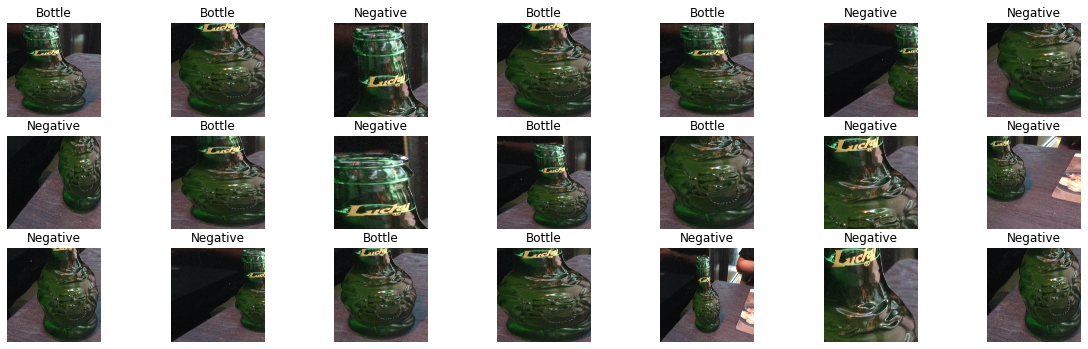

In [112]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(labels[i])
    plt.axis('off')


In [25]:
img = imgs[1]
im_path = dataset_path + "/" + img['file_name']
im = cv2.imread(im_path)
newHeight = int(im.shape[0]/10)
newWidth = int(im.shape[1]*200/im.shape[0])
im = cv2.resize(im, (newWidth, newHeight)) 

ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(im)
ss.switchToSelectiveSearchFast()
rects = ss.process()
print(len(rects))

error: OpenCV(4.6.0) /io/opencv/modules/core/include/opencv2/core/private.cuda.hpp:106: error: (-216:No CUDA support) The library is compiled without CUDA support in function 'throw_no_cuda'
